Adapted from [MultivariateStats.jl](https://juliastats.org/MultivariateStats.jl/stable/pca/).

In [1]:
using BenchmarkTools, RDatasets, Plots

In [2]:
# load iris dataset
iris = dataset("datasets", "iris")

# split half to training set
Xtr = Matrix(iris[1:2:end,1:4])'
Xtr_labels = Vector(iris[1:2:end,5])

# split other half to testing set
Xte = Matrix(iris[2:2:end,1:4])'
Xte_labels = Vector(iris[2:2:end,5]);

# MultivariateStats.jl

## PCA

In [3]:
using MultivariateStats

In [4]:
@benchmark fit(PCA, Xtr; maxoutdim=3)

BenchmarkTools.Trial: 10000 samples with 3 evaluations.
 Range (min … max):  7.829 μs …  2.134 ms  ┊ GC (min … max): 0.00% … 98.43%
 Time  (median):     8.278 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.884 μs ± 34.259 μs  ┊ GC (mean ± σ):  6.34% ±  1.94%

  ██▆▅▄▄▃▃▂▂▁▁▁                                              ▂
  █████████████████████▇▇▆▇▇▇▇▆▇▇▇▇▅▆▇▆▆▄▅▅▅▆▆▆▆▄▄▆▅▁▆▄▅▃▅▁▄ █
  7.83 μs      Histogram: log(frequency) by time     26.4 μs <

 Memory estimate: 6.50 KiB, allocs estimate: 37.

In [5]:
@benchmark predict(M, Xte) setup=(M=fit(PCA, Xtr; maxoutdim=3))

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.139 μs … 751.029 μs  ┊ GC (min … max):  0.00% … 99.01%
 Time  (median):     1.346 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   1.960 μs ±  11.901 μs  ┊ GC (mean ± σ):  15.81% ±  2.92%

  ▇█▇▇▅▄▄▃▃▂▂▂▂▂▃▃▃▃▃▂▁▁▁                                     ▂
  █████████████████████████▇▆█▇▇▇▆▇▆▆▆▇▇▅▆▅▆▅▆▅▆▅▄▅▆▆▅▅▄▃▅▅▅▅ █
  1.14 μs      Histogram: log(frequency) by time      5.38 μs <

 Memory estimate: 4.56 KiB, allocs estimate: 5.

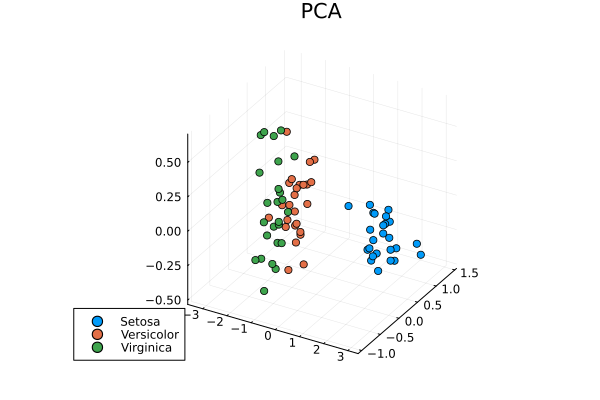

In [6]:
function plot_compression(Yte, title)
    setosa_Y = Yte[:, Xte_labels .== "setosa"]
    versicolor_Y = Yte[:, Xte_labels .== "versicolor"]
    virginica_Y = Yte[:, Xte_labels .== "virginica"]
    p = scatter(setosa_Y[1, :], setosa_Y[2, :], setosa_Y[3, :], marker=:circle, linewidth=0, label="Setosa")
    scatter!(versicolor_Y[1, :], versicolor_Y[2, :], versicolor_Y[3, :], marker=:circle, linewidth=0, label="Versicolor")
    scatter!(virginica_Y[1, :], virginica_Y[2, :], virginica_Y[3, :], marker=:circle, linewidth=0, label="Virginica")
    plot!(p, title=title)
    return p
end

M = fit(PCA, Xtr; maxoutdim=3)
pca_pred = predict(M, Xte)
p1 = plot_compression(pca_pred, "PCA")

# ExpFamilyPCA

## PoissonEPCA

In [7]:
using ExpFamilyPCA

In [8]:
@benchmark PoissonEPCA()

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):   6.111 ns …  2.704 μs  ┊ GC (min … max):  0.00% … 98.31%
 Time  (median):      7.159 ns              ┊ GC (median):     0.00%
 Time  (mean ± σ):   11.505 ns ± 75.028 ns  ┊ GC (mean ± σ):  20.08% ±  3.09%

  ▇█▇▅▃▂▂▁▁▁                       ▁                          ▂
  ███████████▇▆▆▆▅▆▅▅▅▄▅▅▄▆▆▄▅▆▆█▇████▇▇▇▆▅▄▃▅▅▆▆▆▆▆▆▅▅▅▅▅▆▆▆ █
  6.11 ns      Histogram: log(frequency) by time      39.8 ns <

 Memory estimate: 48 bytes, allocs estimate: 1.

In [9]:
Xtr_transpose = Xtr'
@benchmark fit!(poisson, Xtr_transpose; maxoutdim=3, verbose=false, maxiter=100) setup=(poisson=PoissonEPCA())

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 7.538 s (4.40% GC) to evaluate,
 with a memory estimate of 2.63 GiB, over 2215140 allocations.

In [10]:
poisson = PoissonEPCA()
fit!(poisson, Xtr_transpose; maxoutdim=3, verbose=true, maxiter=100, steps_per_print=10)'

Iteration: 1/100 | Loss: 50.666060438300995
Iteration: 10/100 | Loss: 4.625855594711395
Iteration: 20/100 | Loss: 3.519002794344326
Iteration: 30/100 | Loss: 3.164566443003272
Iteration: 40/100 | Loss: 3.002771480502954
Iteration: 50/100 | Loss: 2.855615251963713
Iteration: 60/100 | Loss: 2.813705853116416
Iteration: 70/100 | Loss: 2.813705853116416
Iteration: 80/100 | Loss: 2.813705853116416
Iteration: 90/100 | Loss: 2.813705853116416
Iteration: 100/100 | Loss: 2.813705853116416


3×75 adjoint(::Matrix{Float64}) with eltype Float64:
 0.923188  0.913917  0.92129  …  1.01827   1.04163  1.01696  1.03274
 1.05654   1.04342   1.04729     0.998606  1.00611  1.00809  1.00071
 1.65296   1.66277   1.64053     1.65228   1.66713  1.06961  2.50893

In [11]:
Xte_transpose = Xte'
@benchmark compress(poisson, Xte_transpose; maxiter=100)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  4.986 s …  4.992 s  ┊ GC (min … max): 3.69% … 3.60%
 Time  (median):     4.989 s             ┊ GC (median):    3.64%
 Time  (mean ± σ):   4.989 s ± 4.439 ms  ┊ GC (mean ± σ):  3.64% ± 0.06%

  █                                                      █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  4.99 s        Histogram: frequency by time        4.99 s <

 Memory estimate: 1.68 GiB, allocs estimate: 1287433.

In [12]:
poisson_pred = compress(poisson, Xte_transpose; verbose=true, maxiter=50, steps_per_print=10)'

Iteration: 1/50 | Loss: 37.959223504896734
Iteration: 10/50 | Loss: 10.731506477286258
Iteration: 20/50 | Loss: 7.053026655089925
Iteration: 30/50 | Loss: 6.676890260431074
Iteration: 40/50 | Loss: 6.676890260431074
Iteration: 50/50 | Loss: 6.676890260431074


3×75 adjoint(::Matrix{Float64}) with eltype Float64:
 0.958654  0.956461  0.955193  …  1.0086    1.00879  1.01024  1.00938
 1.11105   1.10744   1.09427      0.995587  1.00357  1.00828  1.01049
 1.13213   1.13282   1.73475      1.12274   1.10187  1.10609  1.11111

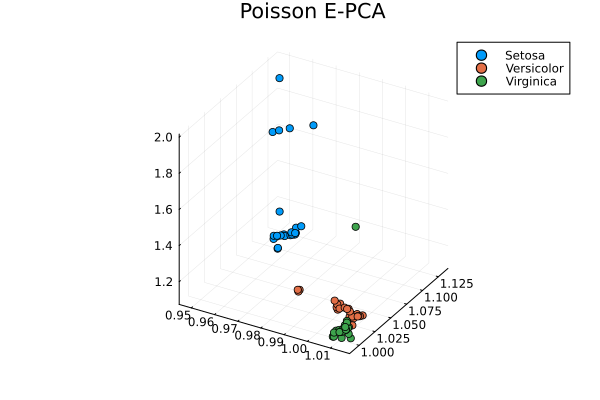

In [13]:
p2 = plot_compression(poisson_pred, "Poisson E-PCA")

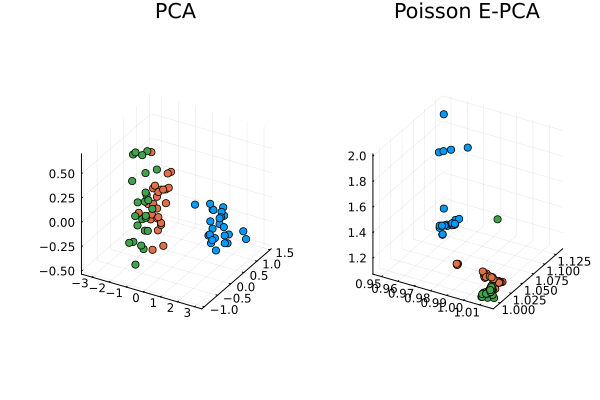

In [14]:
plot(p1, p2, layout=(1, 2), legend=false)

Now, let's see how PCA and Poisson E-PCA fair on reconstruction.

In [15]:
@benchmark reconstruct(M, pca_pred)

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.007 μs …  1.410 ms  ┊ GC (min … max):  0.00% … 99.51%
 Time  (median):     1.348 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.659 μs ± 32.784 μs  ┊ GC (mean ± σ):  37.65% ±  3.14%

  ▆▇▃█▇▂▁▁▁           ▁▂▂▂                                   ▂
  █████████▇▇▆▇▅▆▇▇▇▆████████▇▇████▇▇▇▇▇█▇▆▆▆▆▅▅▅▄▅▄▅▅▄▂▃▃▂▄ █
  1.01 μs      Histogram: log(frequency) by time     6.24 μs <

 Memory estimate: 5.00 KiB, allocs estimate: 2.

In [16]:
Xr_PCA = reconstruct(M, pca_pred)

4×75 Matrix{Float64}:
 4.86449  4.61087   5.40782   5.00775   …  6.79346  6.58825  6.46774  5.94384
 3.04262  3.08695   3.89061   3.39069      3.20785  3.13416  3.03873  2.94737
 1.46099  1.48132   1.68656   1.48668      5.91124  5.39197  5.25542  5.02469
 0.10362  0.229519  0.421233  0.221041     2.28224  1.99665  1.91243  1.91901

In [17]:
poisson_pred_transpose = poisson_pred'
@benchmark decompress(poisson, poisson_pred_transpose)

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.877 μs …  1.220 ms  ┊ GC (min … max):  0.00% … 99.48%
 Time  (median):     2.264 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.397 μs ± 29.789 μs  ┊ GC (mean ± σ):  26.95% ±  3.13%

  ▅▇▆▇█▅▁▁                                                   ▂
  █████████▇█▇▆▇██▇▇██████▇▇██████▇█▇██▇▇▇▆▆▇▅▄▅▅▆▄▄▃▁▄▃▄▄▅▄ █
  1.88 μs      Histogram: log(frequency) by time     7.51 μs <

 Memory estimate: 5.00 KiB, allocs estimate: 2.

In [18]:
Xr_poisson = decompress(poisson, poisson_pred')'

4×75 adjoint(::Matrix{Float64}) with eltype Float64:
 5.38503   5.36581   5.24588   …  6.29964  6.28853  6.29652  6.27787
 3.37805   3.36538   3.79007      2.67623  2.69751  2.71738  2.73231
 1.39961   1.40915   1.37747      5.41043  5.1199   5.00271  4.87542
 0.192321  0.195829  0.216157     1.90578  1.71709  1.64256  1.57361

In [19]:
pca_absolute_error = sum(abs.(Xr_PCA .- Xte))
poisson_absolute_error = sum(abs.(Xr_poisson .- Xte))

println("PCA Absolute Error: ", pca_absolute_error)
println("Poisson Absolute Error: ", poisson_absolute_error)

PCA Absolute Error: 18.37633501091988
Poisson Absolute Error: 88.74532840868083


Both, reconstruct the data nearly instantly.

## Implicit Poisson

One of the main features of ExpFamilyPCA.jl is the ability to induce a custom E-PCA objective from a user-provided convex function $G$. For example, to induce the Poisson E-PCA objective, we set $G = \exp(x)$. While this method is convenient for experimenting with different $G$ and link functinos, it is often slower than an explicit model that defines the Bregman divergence.

In [20]:
@benchmark EPCA(x->exp(x))

BenchmarkTools.Trial: 2027 samples with 1 evaluation.
 Range (min … max):  1.166 ms …  12.576 ms  ┊ GC (min … max): 0.00% … 77.96%
 Time  (median):     2.477 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.455 ms ± 826.894 μs  ┊ GC (mean ± σ):  0.34% ±  2.36%

   ▁▇▆▅▆▄ ▂▁▁ ▅▁▁  ▃ ▁▄▁ ▃▅▇█▅▂▅▃▂▄▂▃▅▁▁                       
  ▅██████████████▇███████████████████████▆█▅▇▆▆▄▄▄▅▃▄▃▃▂▂▂▂▂▂ ▅
  1.17 ms         Histogram: frequency by time        4.34 ms <

 Memory estimate: 64.69 KiB, allocs estimate: 1184.

In [21]:
@benchmark fit!(implicit_poisson, Xtr_transpose; maxoutdim=3, maxiter=100) setup=(implicit_poisson=EPCA(x->exp(x)))

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 9.301 s (21.65% GC) to evaluate,
 with a memory estimate of 13.98 GiB, over 7250355 allocations.

In [22]:
implicit_poisson = EPCA(x->exp(x))
fit!(implicit_poisson, Xtr_transpose; maxoutdim=3, verbose=true, maxiter=100, steps_per_print=10)'

Iteration: 1/100 | Loss: -704.1463309280989
Iteration: 10/100 | Loss: -884.7383173626084
Iteration: 20/100 | Loss: NaN
Iteration: 30/100 | Loss: NaN
Iteration: 40/100 | Loss: NaN
Iteration: 50/100 | Loss: NaN
Iteration: 60/100 | Loss: NaN
Iteration: 70/100 | Loss: NaN
Iteration: 80/100 | Loss: NaN
Iteration: 90/100 | Loss: NaN
Iteration: 100/100 | Loss: NaN


3×75 adjoint(::Matrix{Float64}) with eltype Float64:
 0.947084  0.934675  0.944017  …  0.997077  1.02177  1.00501  1.00825
 1.00642   1.00812   1.00941      1.02204   1.02104  1.02212  1.02035
 1.56287   1.1663    1.25496      1.01511   1.01737  1.02262  1.02571

In [23]:
@benchmark compress(implicit_poisson, Xte_transpose; maxiter=100)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 33.621 s (24.56% GC) to evaluate,
 with a memory estimate of 55.32 GiB, over 27337603 allocations.

In [24]:
implicit_poisson_pred = compress(implicit_poisson, Xte_transpose; verbose=true, maxiter=100)'

Iteration: 1/100 | Loss: -720.0162693917835
Iteration: 10/100 | Loss: -887.20391818504
Iteration: 20/100 | Loss: -895.1956947997506
Iteration: 30/100 | Loss: -898.1522155513308
Iteration: 40/100 | Loss: -900.2006041955245
Iteration: 50/100 | Loss: NaN
Iteration: 60/100 | Loss: NaN
Iteration: 70/100 | Loss: NaN
Iteration: 80/100 | Loss: NaN
Iteration: 90/100 | Loss: NaN
Iteration: 100/100 | Loss: NaN


3×75 adjoint(::Matrix{Float64}) with eltype Float64:
 0.996386  1.00403  1.00051  0.994582  …  1.0271   1.02376  1.02192  1.02308
 1.1009    1.11652  1.08895  1.09428      1.03071  1.03419  1.03438  1.04715
 1.13882   1.10003  1.32486  1.20177      1.03933  1.0494   1.04819  1.04863

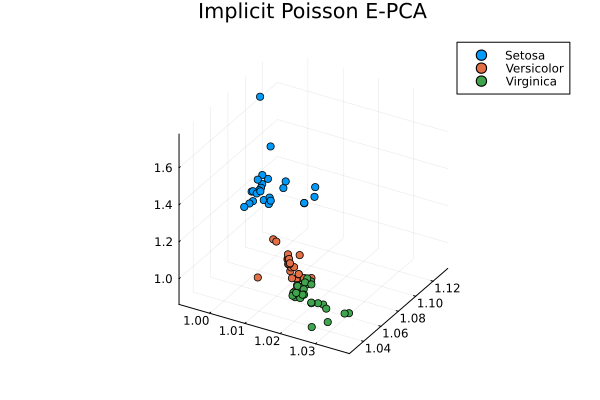

In [25]:
p3 = plot_compression(implicit_poisson_pred, "Implicit Poisson E-PCA")

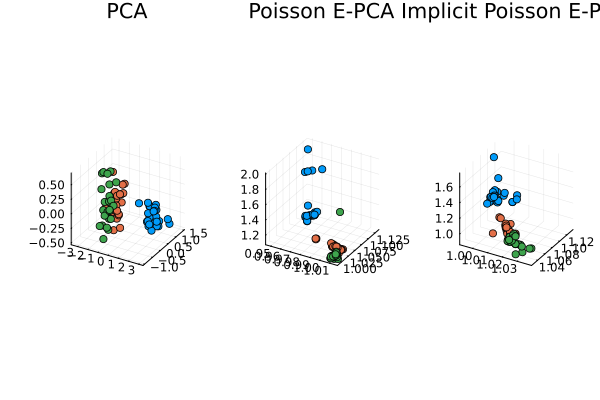

In [26]:
plot(p1, p2, p3, layout=(1, 3), legend=false)